In [1]:
# Install the snowdroughtindex package
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main

# Install required packages
#%pip install numpy pandas xarray geopandas matplotlib shapely scipy scikit-learn 

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import gamma, norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
import sys
from pathlib import Path
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Import snowdroughtindex package
from snowdroughtindex.core import sswei

In [2]:
# Configuration
config = {
    'SWEI_input_dir': project_root / 'data' / 'output_data' /  '1980_2024' / 'comparison'/ 'For_SWEI_calculation.csv',
    'SPI_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'monthly_SPI_2005_unstacked.csv',
    'SnoDRI_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'monthly_SnoDRI_2005_unstacked.csv',
    'normalized': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'Drought_Indices_Comparison_Normalized.csv',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles' / 'BowRiverBasin' / 'Bow_elevation_combined.shp',
    'output_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024' / 'comparison',
}

# Create output directories
config['output_dir'].mkdir(parents=True, exist_ok=True)
config['plots'].mkdir(parents=True, exist_ok=True)

print("Configuration set")
print(f"Output directory: {config['output_dir']}")

Configuration set
Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison


# Calculate monthly SWEI for 2023

In [3]:
# load SWEI input data
swe_df = pd.read_csv(config['SWEI_input_dir'], parse_dates=['date'])
print(f"Loaded SWEI input data from: {config['SWEI_input_dir']}")

#drop columns if they exist
cols_to_drop = ['time', 'lon','lat']
swe_df = swe_df.drop(columns=[col for col in cols_to_drop if col in swe_df.columns], errors='ignore')

# add month column
swe_df['month'] = swe_df['date'].dt.month

# select data for season 2023 (Oct 2023 to Sep 2024)
swe_df = swe_df[(swe_df['date'] >= '2023-10-01') & (swe_df['date'] < '2024-10-01')]


display(swe_df.head())

Loaded SWEI input data from: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\For_SWEI_calculation.csv


,date,Grid_id,SWE,Elevation_Category,season_year,daily_SWE_change,month
10459,2023-10-01,1,4.875000,2000_2500m,2023,0.0,10
10460,2023-10-02,1,4.375000,2000_2500m,2023,0.0,10
10461,2023-10-03,1,3.250000,2000_2500m,2023,0.0,10
10462,2023-10-04,1,1.935242,2000_2500m,2023,0.0,10
10463,2023-10-05,1,1.500000,2000_2500m,2023,0.0,10


In [4]:
# perturb daily_SWE_change for both subsets
swe_df['perturb_SWE'] = sswei.perturb_zeros(swe_df['daily_SWE_change'])

display(swe_df.head())

,date,Grid_id,SWE,Elevation_Category,season_year,daily_SWE_change,month,perturb_SWE
10459,2023-10-01,1,4.875000,2000_2500m,2023,0.0,10,0.000015
10460,2023-10-02,1,4.375000,2000_2500m,2023,0.0,10,0.000003
10461,2023-10-03,1,3.250000,2000_2500m,2023,0.0,10,0.000002
10462,2023-10-04,1,1.935242,2000_2500m,2023,0.0,10,0.000006
10463,2023-10-05,1,1.500000,2000_2500m,2023,0.0,10,0.000012


In [5]:
# Sum daily_SWE_change by Grid_id and month
sum_daily_SWE = (
    swe_df
    .groupby(['Grid_id', 'month'], as_index=False)['daily_SWE_change']
    .sum()
    .rename(columns={'daily_SWE_change': 'sum_daily_SWE_change'})
)
#keep Elevation column
sum_daily_SWE = sum_daily_SWE.merge(swe_df[['Grid_id', 'Elevation_Category']].drop_duplicates(), on='Grid_id', how='left')

display(sum_daily_SWE.head())


,Grid_id,month,sum_daily_SWE_change,Elevation_Category
0,1,1,41.62500,2000_2500m
1,1,2,45.37500,2000_2500m
2,1,3,32.12500,2000_2500m
3,1,4,34.46875,2000_2500m
4,1,5,5.01465,2000_2500m


In [6]:
# integrate perturb_SWE by Grid_id, season_year, month
def _integrate_perturb(group):
    group = group.sort_values('date')
    if group.shape[0] < 2:
        # single observation -> zero-area (or you could set to NaN)
        return pd.Series({
            'integrated_perturb_SWE': 0.0,
            'n_obs': int(group.shape[0]),
            'start_date': group['date'].iloc[0],
            'end_date': group['date'].iloc[0]
        })
    # x in days since first observation
    x = (group['date'] - group['date'].iloc[0]).dt.total_seconds() / 86400.0
    y = group['perturb_SWE'].values
    area = trapz(y, x)
    return pd.Series({
        'integrated_perturb_SWE': float(area),
        'n_obs': int(group.shape[0]),
        'start_date': group['date'].iloc[0],
        'end_date': group['date'].iloc[-1]
    })

perturb_integrated = swe_df.groupby(['Grid_id', 'season_year', 'month']).apply(_integrate_perturb).reset_index()

#keep elevation category
elevation_mapping = swe_df[['Grid_id', 'Elevation_Category']].drop_duplicates()

perturb_integrated = perturb_integrated.merge(elevation_mapping, on='Grid_id', how='left')

display(perturb_integrated)

,Grid_id,season_year,month,integrated_perturb_SWE,n_obs,start_date,end_date,Elevation_Category
0,1,2023,1,41.000014,31,2024-01-01,2024-01-31,2000_2500m
1,1,2023,2,41.187555,29,2024-02-01,2024-02-29,2000_2500m
2,1,2023,3,30.375115,31,2024-03-01,2024-03-31,2000_2500m
3,1,2023,4,34.468910,30,2024-04-01,2024-04-30,2000_2500m
4,1,2023,5,4.577385,31,2024-05-01,2024-05-31,2000_2500m
...,...,...,...,...,...,...,...,...
2051,257,2023,4,7.420109,30,2024-04-01,2024-04-30,500_1000m
2052,257,2023,5,1.326373,31,2024-05-01,2024-05-31,500_1000m
2053,257,2023,10,9.750172,31,2023-10-01,2023-10-31,500_1000m
2054,257,2023,11,2.635969,30,2023-11-01,2023-11-30,500_1000m


In [7]:
# 3. Gringorten plotting position calculation
# Apply gringorten_probabilities grouped by coordinate_id
sum_daily_SWE['gringorten_probability'] = sum_daily_SWE.groupby('Grid_id')['sum_daily_SWE_change'].transform(sswei.gringorten_probabilities)

# Display the updated DataFrame
display(sum_daily_SWE)

,Grid_id,month,sum_daily_SWE_change,Elevation_Category,gringorten_probability
0,1,1,41.625000,2000_2500m,0.684729
1,1,2,45.375000,2000_2500m,0.807882
2,1,3,32.125000,2000_2500m,0.438424
3,1,4,34.468750,2000_2500m,0.561576
4,1,5,5.014650,2000_2500m,0.068966
...,...,...,...,...,...
2051,257,4,7.419922,500_1000m,0.438424
2052,257,5,2.652344,500_1000m,0.192118
2053,257,10,9.750000,500_1000m,0.561576
2054,257,11,2.635773,500_1000m,0.068966


In [8]:
#4. Compute standardized SWEI
# Compute SSWEI grouped by coordinate_id
sum_daily_SWE['SSWEI'] = sum_daily_SWE.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(sum_daily_SWE)

,Grid_id,month,sum_daily_SWE_change,Elevation_Category,gringorten_probability,SSWEI
0,1,1,41.625000,2000_2500m,0.684729,0.480964
1,1,2,45.375000,2000_2500m,0.807882,0.870117
2,1,3,32.125000,2000_2500m,0.438424,-0.154967
3,1,4,34.468750,2000_2500m,0.561576,0.154967
4,1,5,5.014650,2000_2500m,0.068966,-1.483540
...,...,...,...,...,...,...
2051,257,4,7.419922,500_1000m,0.438424,-0.154967
2052,257,5,2.652344,500_1000m,0.192118,-0.870117
2053,257,10,9.750000,500_1000m,0.561576,0.154967
2054,257,11,2.635773,500_1000m,0.068966,-1.483540


In [9]:
# Group by season_year and calculate the mean SSWEI for each year
# Group by Season_year and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI_per_year = sum_daily_SWE.groupby(['month', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI_per_year = average_SSWEI_per_year.pivot(index='month', columns='Elevation_Category', values='SSWEI').reset_index()

# No need to rename columns here, as the pivot already gives correct column names

# Display the result
display(average_SSWEI_per_year)

Elevation_Category,month,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,1,0.154736,0.248881,0.281867,0.479556
1,2,0.139087,0.527934,0.944100,0.425965
2,3,1.422198,1.173868,0.428596,1.467109
3,4,0.857839,0.780687,0.194183,-0.033544
4,5,-0.736384,-0.596621,-0.890213,-1.313753
5,10,-0.517969,-0.692219,-0.803574,-0.171773
6,11,-1.483540,-1.430961,-0.960228,-1.036429
7,12,0.164033,-0.011571,0.805267,0.182869


In [10]:
# load shapefile
bow_basin = gpd.read_file(config['shapefile_dir'])
# print column names
print(bow_basin.elev_class)

0      500_1000m
1      500_1000m
2     1000_1500m
3     1000_1500m
4     1500_2000m
5     1500_2000m
6     1500_2000m
7     1500_2000m
8     2000_2500m
9     2000_2500m
10    2000_2500m
11    2000_2500m
12    2000_2500m
Name: elev_class, dtype: object


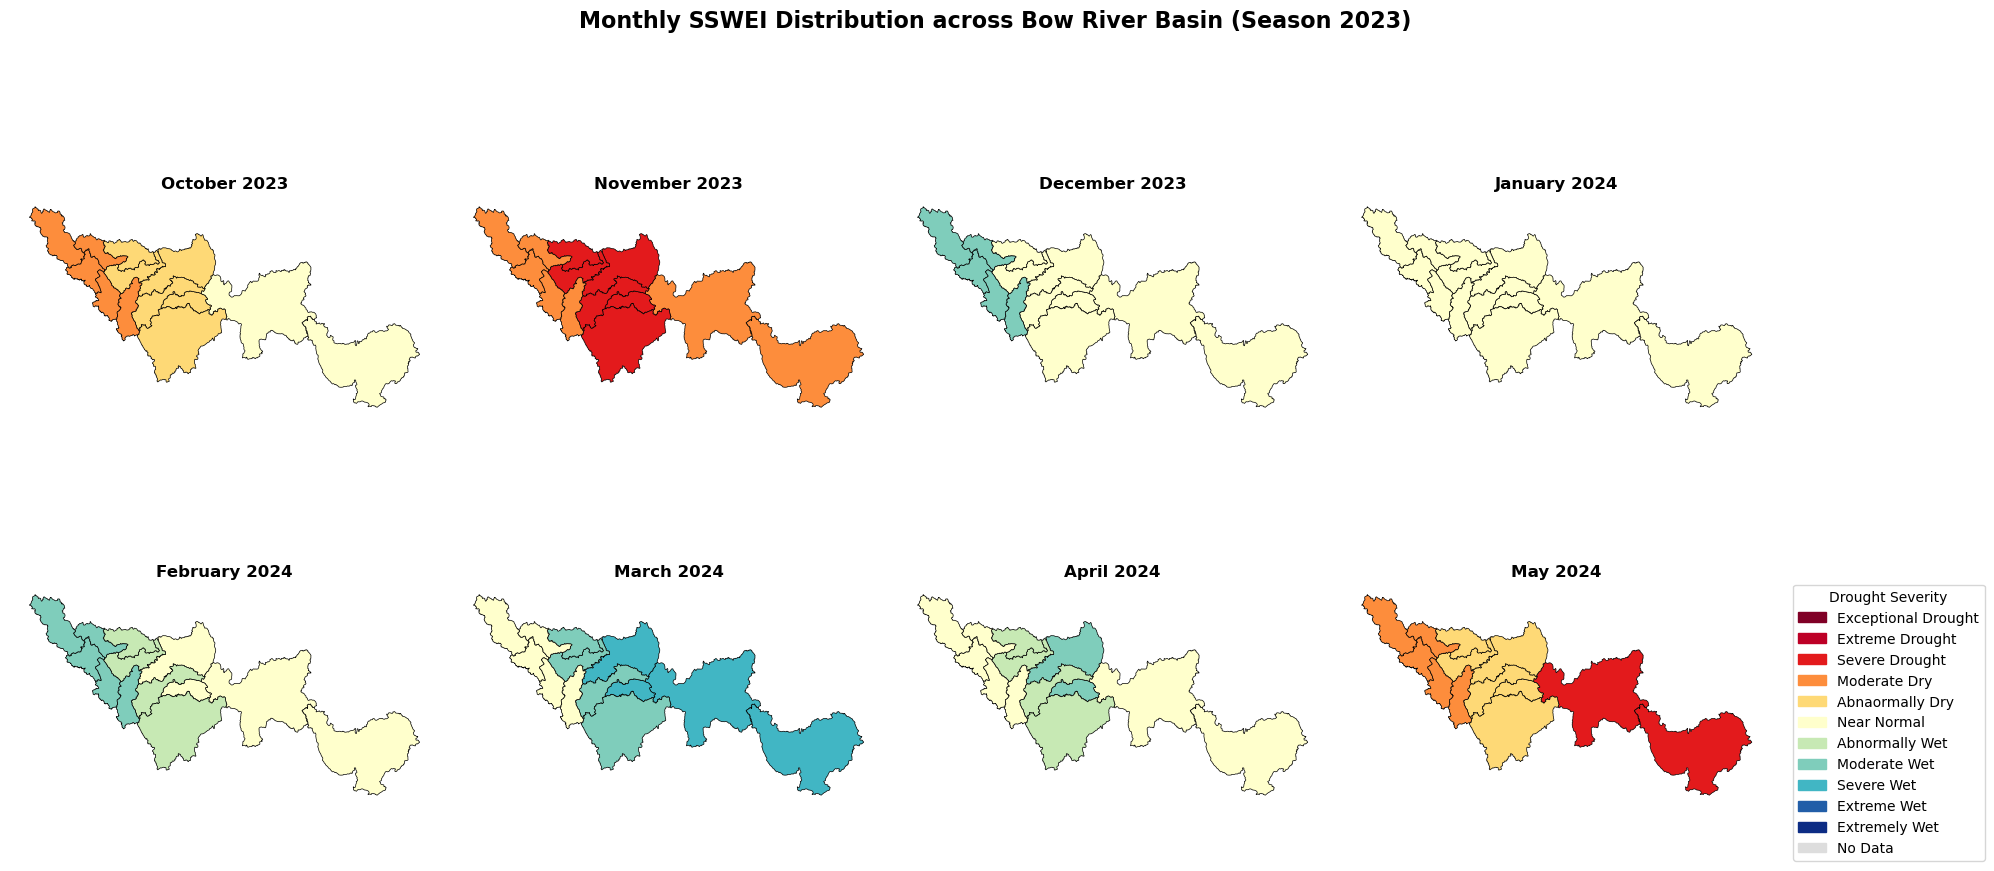

In [11]:
# Plot monthly SSWEI on bow basin subplots

# Desired month order: October (10) to May (5)
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
# Keep only months that actually exist in the data, in the desired order
available_months = average_SSWEI_per_year['month'].unique().tolist()
months = [m for m in month_order if m in available_months]

n_months = len(months)

# Create subplot grid (2 rows x 4 columns for up to 8 months)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Define a color map for drought severity (keys match classify_sswei output)
severity_colors_SWEI = {
    'Exceptional Drought': '#800026',
    'Extreme Drought': '#BD0026',
    'Severe Drought': '#E31A1C',
    'Moderate Dry': '#FD8D3C',
    'Abnaormally Dry': '#FED976',
    'Near Normal': '#FFFFCC',
    'Abnormally Wet': '#C7E9B4',
    'Moderate Wet': '#7FCDBB',
    'Severe Wet': '#41B6C4',
    'Extreme Wet': '#225EA8',
    'Extremely Wet': '#0C2C84',
    'No Data': '#dddddd'
}

# Create a classification function for SSWEI values
# (same thresholds as before)
def classify_sswei(value):
    if pd.isna(value):
        return 'No Data'
    elif value <= -2.0:
        return 'Exceptional Drought'
    elif value < -1.6:
        return 'Extreme Drought'
    elif value < -1.3:
        return 'Severe Drought'
    elif value < -0.8:
        return 'Moderate Dry'
    elif value < -0.5:
        return 'Abnaormally Dry'
    elif value < 0.5:
        return 'Near Normal'
    elif value < 0.8:
        return 'Abnormally Wet'
    elif value < 1.3:
        return 'Moderate Wet'
    elif value < 1.6:
        return 'Severe Wet'
    elif value < 2.0:
        return 'Extreme Wet'
    else:
        return 'Extremely Wet'

# Initialize color column (will be updated per month in the loop)
bow_basin['color'] = '#dddddd'

# Month names for titles
month_names = {10: 'October', 11: 'November', 12: 'December',
               1: 'January', 2: 'February', 3: 'March',
               4: 'April', 5: 'May'}

# Plot each month
for idx, month in enumerate(months):
    ax = axes[idx]

    # Subset SSWEI for this month
    month_data = average_SSWEI_per_year[average_SSWEI_per_year['month'] == month].copy()

    # Melt month_data to convert elevation columns to rows
    # Use a temporary value_name that cannot collide with existing columns
    month_data_long = month_data.melt(
        id_vars=['month'],
        var_name='Elevation_Category',
        value_name='SSWEI_value'
    )
    # Rename to SSWEI for clarity downstream
    month_data_long = month_data_long.rename(columns={'SSWEI_value': 'SSWEI'})

    # Merge SSWEI values with basin geometry using elevation categories
    basin_plot = bow_basin.merge(
        month_data_long[['Elevation_Category', 'SSWEI']],
        left_on='elev_class',
        right_on='Elevation_Category',
        how='left'
    )

    # Classify SSWEI values and assign colors
    basin_plot['Drought_Classification'] = basin_plot['SSWEI'].apply(classify_sswei)
    basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SWEI).fillna('#dddddd')

    # Plot the basin with SSWEI values
    basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

    # Determine the correct year based on month
    year = 2023 if month >= 10 else 2024
    ax.set_title(f"{month_names.get(month, str(month))} {year}", fontsize=12, fontweight='bold')
    ax.axis('off')

# Hide any unused subplots (if fewer than 8 months)
for j in range(n_months, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Monthly SSWEI Distribution across Bow River Basin (Season 2023)',
             fontsize=16, fontweight='bold', y=0.98)

plt.legend(handles=[mpatches.Patch(color=color, label=label) for label, color in severity_colors_SWEI.items()],
           bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Drought Severity')
plt.tight_layout()

# Save figure (optional)
# out_file_map = config['plots'] / 'SSWEI_bow_basin_monthly_2023.png'
# fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
plt.show()

# 3-mo SWEI

In [15]:
# 3-month sum of daily_SWE_change per Grid_id and season_year (ordered Oct–May)
monthly_sum = (
    swe_df
    .groupby(['Grid_id', 'season_year', 'month'], as_index=False)['daily_SWE_change']
    .sum()
    .rename(columns={'daily_SWE_change': 'sum_daily_SWE_change'})
)

# ensure month is ordered as the defined season (uses existing month_order)
monthly_sum['month'] = pd.Categorical(monthly_sum['month'], categories=month_order, ordered=True)
monthly_sum = monthly_sum.sort_values(['Grid_id', 'season_year', 'month'])

# rolling 3-month window within each Grid_id/season_year
monthly_sum['sum_SWE_3mo'] = (
    monthly_sum
    .groupby(['Grid_id', 'season_year'])['sum_daily_SWE_change']
    .transform(lambda s: s.rolling(window=3, min_periods=3).sum())
)

# keep elevation column (uses existing elevation_mapping)
sum_daily_SWE = monthly_sum[monthly_sum['sum_SWE_3mo'].notna()].merge(
    elevation_mapping, on='Grid_id', how='left'
)

display(sum_daily_SWE.head())

,Grid_id,season_year,month,sum_daily_SWE_change,sum_SWE_3mo,Elevation_Category
0,1,2023,12,49.75000,89.029724,2000_2500m
1,1,2023,1,41.62500,111.125000,2000_2500m
2,1,2023,2,45.37500,136.750000,2000_2500m
3,1,2023,3,32.12500,119.125000,2000_2500m
4,1,2023,4,34.46875,111.968750,2000_2500m


In [17]:
# 3-month rolling sum of integrated perturbation (ordered Oct–May)
p3mo_perturb_integrated = perturb_integrated.copy()
p3mo_perturb_integrated['month'] = pd.Categorical(
    p3mo_perturb_integrated['month'], categories=month_order, ordered=True
)
p3mo_perturb_integrated = p3mo_perturb_integrated.sort_values(['Grid_id', 'season_year', 'month'])
p3mo_perturb_integrated['integrated_perturb_SWE_3mo'] = (
    p3mo_perturb_integrated
    .groupby(['Grid_id', 'season_year'])['integrated_perturb_SWE']
    .transform(lambda s: s.rolling(window=3, min_periods=3).sum())
)
p3mo_perturb_integrated = p3mo_perturb_integrated[p3mo_perturb_integrated['integrated_perturb_SWE_3mo'].notna()]

display(p3mo_perturb_integrated)

,Grid_id,season_year,month,integrated_perturb_SWE,n_obs,start_date,end_date,Elevation_Category,integrated_perturb_SWE_3mo
7,1,2023,12,48.375025,31,2023-12-01,2023-12-31,2000_2500m,87.529932
0,1,2023,1,41.000014,31,2024-01-01,2024-01-31,2000_2500m,109.000113
1,1,2023,2,41.187555,29,2024-02-01,2024-02-29,2000_2500m,130.562594
2,1,2023,3,30.375115,31,2024-03-01,2024-03-31,2000_2500m,112.562684
3,1,2023,4,34.468910,30,2024-04-01,2024-04-30,2000_2500m,106.031580
...,...,...,...,...,...,...,...,...,...
2048,257,2023,1,16.125592,31,2024-01-01,2024-01-31,500_1000m,24.540387
2049,257,2023,2,14.123660,29,2024-02-01,2024-02-29,500_1000m,36.028078
2050,257,2023,3,26.499107,31,2024-03-01,2024-03-31,500_1000m,56.748359
2051,257,2023,4,7.420109,30,2024-04-01,2024-04-30,500_1000m,48.042876


In [22]:
# 3-mo Gringorten plotting position calculation on 3-month rolling sums
sum_daily_SWE['gringorten_probability_3mo'] = (
    sum_daily_SWE
    .groupby('Grid_id')['sum_SWE_3mo']
    .transform(sswei.gringorten_probabilities)
)

# 3-mo SSWEI
sum_daily_SWE['SSWEI_3mo'] = (
    sum_daily_SWE
    .groupby('Grid_id')['gringorten_probability_3mo']
    .transform(sswei.compute_swei)
)

display(sum_daily_SWE)

,Grid_id,season_year,month,sum_daily_SWE_change,sum_SWE_3mo,Elevation_Category,gringorten_probability_3mo,SSWEI_3mo
0,1,2023,12,49.750000,89.029724,2000_2500m,0.254902,-0.659143
1,1,2023,1,41.625000,111.125000,2000_2500m,0.418301,-0.206243
2,1,2023,2,45.375000,136.750000,2000_2500m,0.908497,1.331555
3,1,2023,3,32.125000,119.125000,2000_2500m,0.745098,0.659143
4,1,2023,4,34.468750,111.968750,2000_2500m,0.581699,0.206243
...,...,...,...,...,...,...,...,...
1537,257,2023,1,16.125977,24.914825,500_1000m,0.254902,-0.659143
1538,257,2023,2,14.124023,36.403076,500_1000m,0.418301,-0.206243
1539,257,2023,3,27.124023,57.374023,500_1000m,0.908497,1.331555
1540,257,2023,4,7.419922,48.667969,500_1000m,0.745098,0.659143


In [23]:
# Group by season_year and calculate the mean SSWEI for each year
# Group by Season_year and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI = sum_daily_SWE.groupby(['month', 'Elevation_Category'])['SSWEI_3mo'].mean().reset_index()
average_SSWEI = average_SSWEI.pivot(index='month', columns='Elevation_Category', values='SSWEI_3mo').reset_index()

# No need to rename columns here, as the pivot already gives correct column names

# Display the result
display(average_SSWEI)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_31060\3093742891.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_SSWEI = sum_daily_SWE.groupby(['month', 'Elevation_Category'])['SSWEI_3mo'].mean().reset_index()


Elevation_Category,month,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,10,NaN,NaN,NaN,NaN
1,11,NaN,NaN,NaN,NaN
2,12,-1.264314,-1.331555,-1.047339,-1.241376
3,1,-0.726384,-0.633263,-0.254584,-0.660731
4,2,-0.178744,0.016404,0.806022,0.135192
5,3,0.462424,0.647555,0.658808,1.151197
6,4,1.264314,1.091011,0.443958,0.768797
7,5,0.442704,0.209848,-0.606864,-0.153079


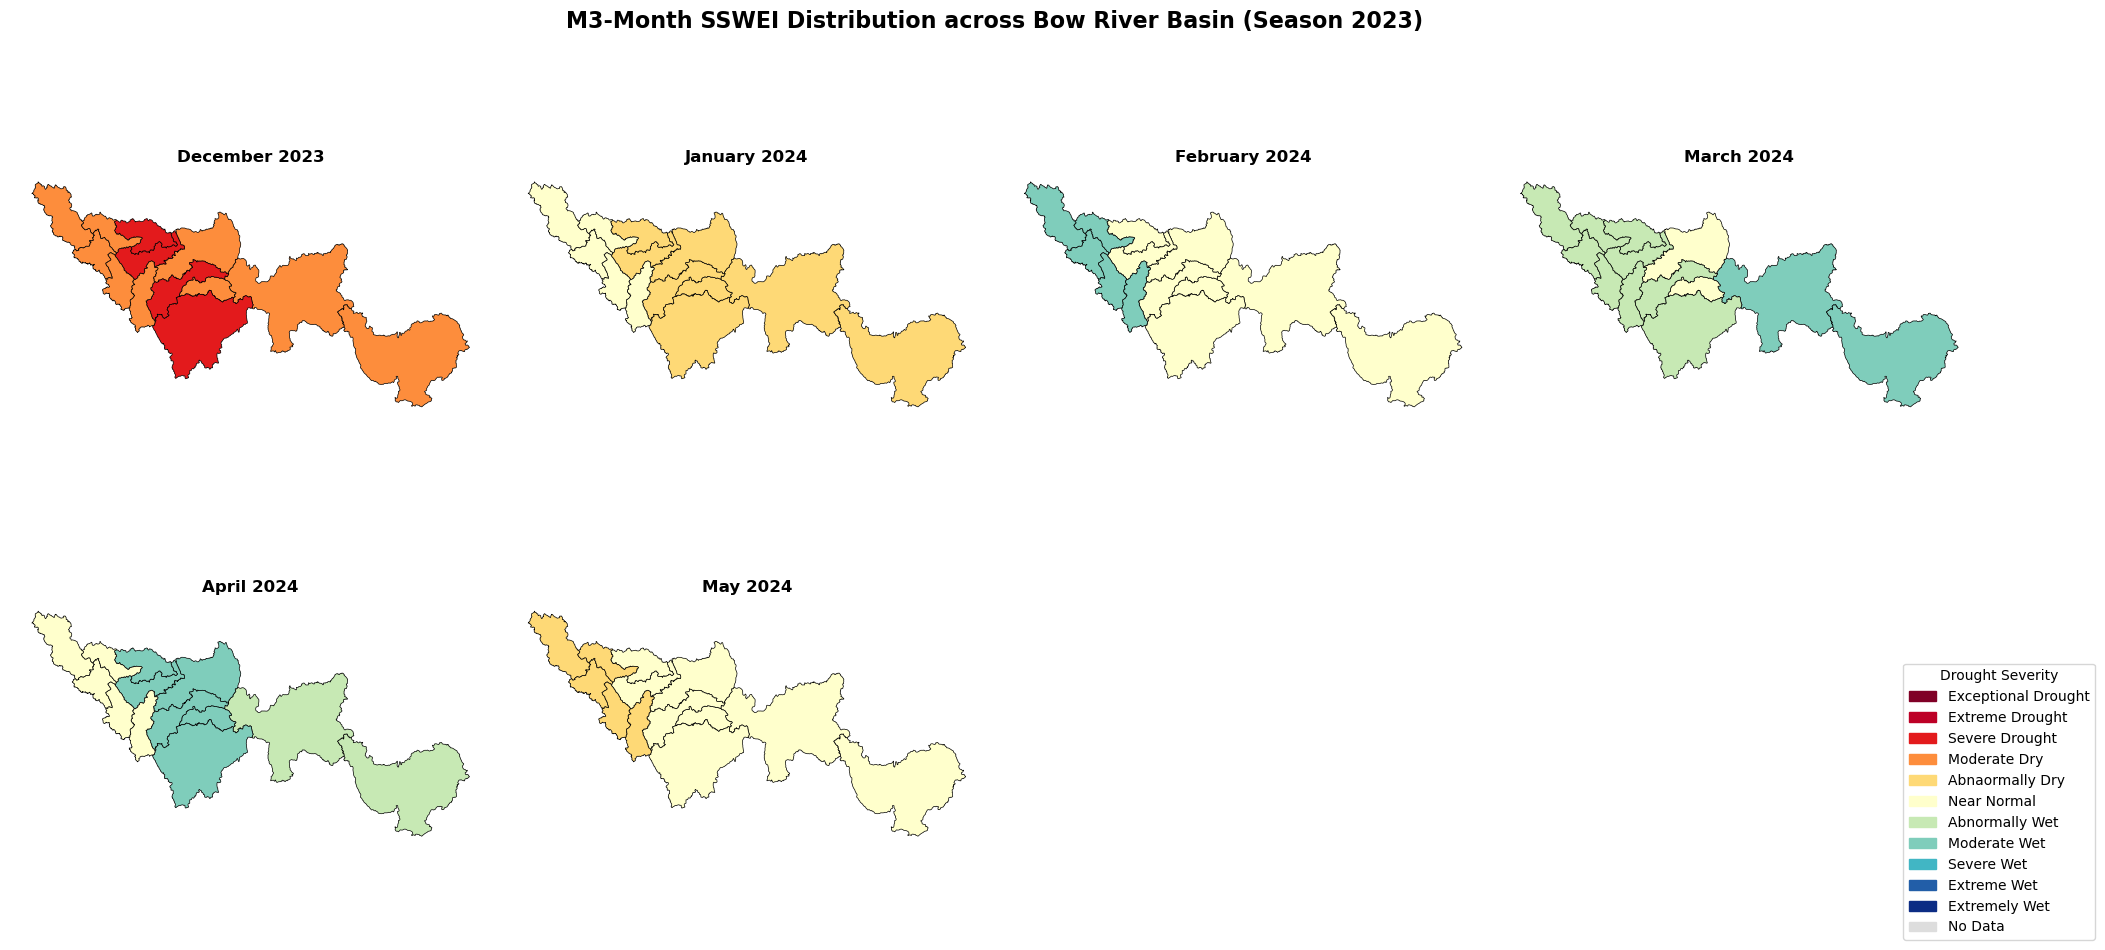

In [35]:
# Plot monthly SSWEI on bow basin subplots

# Desired month order: October (10) to May (5)
month_order = [12, 1, 2, 3, 4, 5]
# Keep only months that actually exist in the data, in the desired order
available_months = average_SSWEI['month'].unique().tolist()
months = [m for m in month_order if m in available_months]

n_months = len(months)

# Create subplot grid (2 rows x 4 columns for up to 8 months)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Define a color map for drought severity (keys match classify_sswei output)
severity_colors_SWEI = {
    'Exceptional Drought': '#800026',
    'Extreme Drought': '#BD0026',
    'Severe Drought': '#E31A1C',
    'Moderate Dry': '#FD8D3C',
    'Abnaormally Dry': '#FED976',
    'Near Normal': '#FFFFCC',
    'Abnormally Wet': '#C7E9B4',
    'Moderate Wet': '#7FCDBB',
    'Severe Wet': '#41B6C4',
    'Extreme Wet': '#225EA8',
    'Extremely Wet': '#0C2C84',
    'No Data': '#dddddd'
}

# Create a classification function for SSWEI values
# (same thresholds as before)
def classify_sswei(value):
    if pd.isna(value):
        return 'No Data'
    elif value <= -2.0:
        return 'Exceptional Drought'
    elif value < -1.6:
        return 'Extreme Drought'
    elif value < -1.3:
        return 'Severe Drought'
    elif value < -0.8:
        return 'Moderate Dry'
    elif value < -0.5:
        return 'Abnaormally Dry'
    elif value < 0.5:
        return 'Near Normal'
    elif value < 0.8:
        return 'Abnormally Wet'
    elif value < 1.3:
        return 'Moderate Wet'
    elif value < 1.6:
        return 'Severe Wet'
    elif value < 2.0:
        return 'Extreme Wet'
    else:
        return 'Extremely Wet'

# Initialize color column (will be updated per month in the loop)
bow_basin['color'] = '#dddddd'

# Month names for titles
month_names = {12: 'December',
               1: 'January', 2: 'February', 3: 'March',
               4: 'April', 5: 'May'}

# Plot each month
for idx, month in enumerate(months):
    ax = axes[idx]

    # Subset SSWEI for this month
    month_data = average_SSWEI[average_SSWEI['month'] == month].copy()

    # Melt month_data to convert elevation columns to rows
    # Use a temporary value_name that cannot collide with existing columns
    month_data_long = month_data.melt(
        id_vars=['month'],
        var_name='Elevation_Category',
        value_name='SSWEI_value'
    )
    # Rename to SSWEI for clarity downstream
    month_data_long = month_data_long.rename(columns={'SSWEI_value': 'SSWEI'})

    # Merge SSWEI values with basin geometry using elevation categories
    basin_plot = bow_basin.merge(
        month_data_long[['Elevation_Category', 'SSWEI']],
        left_on='elev_class',
        right_on='Elevation_Category',
        how='left'
    )

    # Classify SSWEI values and assign colors
    basin_plot['Drought_Classification'] = basin_plot['SSWEI'].apply(classify_sswei)
    basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SWEI).fillna('#dddddd')

    # Plot the basin with SSWEI values
    basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

    # Determine the correct year based on month
    year = 2023 if month >= 10 else 2024
    ax.set_title(f"{month_names.get(month, str(month))} {year}", fontsize=12, fontweight='bold')
    ax.axis('off')

# Hide any unused subplots (if fewer than 8 months)
for j in range(n_months, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('M3-Month SSWEI Distribution across Bow River Basin (Season 2023)',
             fontsize=16, fontweight='bold', y=0.98)

handles = [mpatches.Patch(color=color, label=label) for label, color in severity_colors_SWEI.items()]
fig.legend(handles=handles,
           loc='lower right',
           bbox_to_anchor=(1.05, 0.05),
           borderaxespad=0.,
           title='Drought Severity')
plt.tight_layout()

# Save figure (optional)
# out_file_map = config['plots'] / 'SSWEI_bow_basin_monthly_2023.png'
# fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
plt.show()

# SPI and SnoDRI


In [12]:
# load SPI and SnoDRI data
spi_df = pd.read_csv(config['SPI_dir'])
snodri_df = pd.read_csv(config['SnoDRI_dir'])

display(spi_df.head())
display(snodri_df.head())

,month,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI
0,10,-0.052669,-0.013912,0.549937,0.393079
1,11,0.131721,0.276616,-0.712863,-0.074196
2,12,-1.209708,-1.036021,-1.424022,-0.908139
3,1,-0.349224,-0.382049,0.390312,0.233379
4,2,0.466405,0.035853,-0.213536,0.368217


,month,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,10,-0.115257,-0.069547,-0.442011,0.290900
1,11,-0.813266,-0.493289,-1.002818,-0.851282
2,12,-1.319670,-1.064800,-1.548815,-1.061381
3,1,-1.560030,-1.309877,-1.194094,-0.645319
4,2,-1.733270,-1.635242,-1.514538,-1.579057


In [13]:
# Plot SSWEI, SPI, and SnoDRI by elevation categories
merged = average_SSWEI_per_year.merge(spi_df, on='month').merge(snodri_df, on='month')
display(merged.head())

,month,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,1,0.154736,0.248881,0.281867,0.479556,-0.349224,-0.382049,0.390312,0.233379,-1.560030,-1.309877,-1.194094,-0.645319
1,2,0.139087,0.527934,0.944100,0.425965,0.466405,0.035853,-0.213536,0.368217,-1.733270,-1.635242,-1.514538,-1.579057
2,3,1.422198,1.173868,0.428596,1.467109,-0.891061,-1.640496,-0.784207,0.422021,-1.222573,-1.564547,-1.140520,-0.390085
3,4,0.857839,0.780687,0.194183,-0.033544,-0.159193,-0.427991,0.554801,0.658789,-0.419585,-0.697759,-0.351740,0.677528
4,5,-0.736384,-0.596621,-0.890213,-1.313753,-0.376534,-0.464000,-0.473230,0.435772,0.514175,0.246189,0.280825,1.513291


NameError: name 'out_file2' is not defined

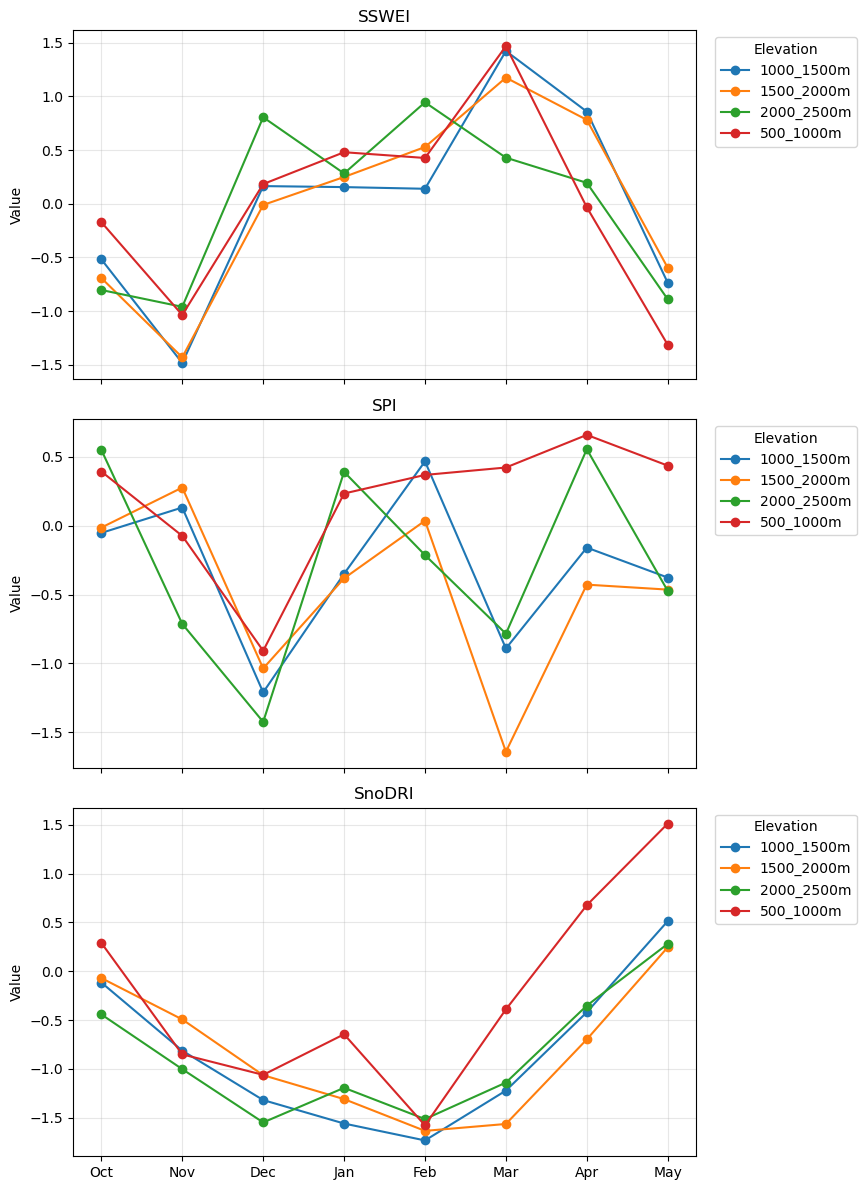

In [14]:
# Plot three separate graphs (SSWEI, SPI, SnoDRI) from `merged`
# Uses existing variables: merged, month_order, elev_colors, out_file2

# prepare month ordering
try:
    merged_plot = merged.set_index('month').loc[month_order].reset_index()
except Exception:
    merged_plot = merged.copy()

# determine elevation category columns (base names without suffixes)
elevations = [c for c in merged_plot.columns if c != 'month' and not c.endswith('_SPI') and not c.endswith('_SnoDRI')]
elevations = sorted(elevations)

# define indices and labels
suffixes = [('', 'SSWEI'), ('_SPI', 'SPI'), ('_SnoDRI', 'SnoDRI')]

# x positions and month labels
x = np.arange(len(merged_plot))
month_labels = pd.to_datetime(merged_plot['month'].astype(str), format='%m').dt.strftime('%b')

# create figure with 3 stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for ax, (suf, title) in zip(axes, suffixes):
    for elev in elevations:
        col = elev + suf
        if col in merged_plot.columns:
            color = elev_colors.get(elev) if 'elev_colors' in globals() else None
            ax.plot(x, merged_plot[col], marker='o', label=elev, color=color)
    ax.set_title(title)
    ax.set_ylabel('Value')
    ax.grid(alpha=0.3)
    ax.legend(title='Elevation', bbox_to_anchor=(1.02, 1), loc='upper left')

# finalize x-axis
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(month_labels)
fig.tight_layout(rect=[0, 0, 0.88, 1])  # leave space for legends
fig.savefig(out_file2, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Normalize merged using the same per-column min/max found in normalized_df
cols_to_norm = [c for c in merged.columns if c != 'month']
merged_normalized = merged.copy()

for col in cols_to_norm:
    # try to find matching column in normalized_df
    if col in normalized_df.columns:
        ref_col = col
    elif col.endswith('_SnoDRI') and f"{col}_z" in normalized_df.columns:
        ref_col = f"{col}_z"
    else:
        ref_col = None

    if ref_col is not None:
        ref_min = normalized_df[ref_col].min()
        ref_max = normalized_df[ref_col].max()
    else:
        # fallback to merged's own range if no reference scale available
        ref_min = merged[col].min()
        ref_max = merged[col].max()

    if ref_max == ref_min:
        # avoid division by zero
        merged_normalized[col] = 0.0
    else:
        merged_normalized[col] = (merged[col] - ref_min) / (ref_max - ref_min)
        merged_normalized[col] = merged_normalized[col].clip(0.0, 1.0)

display(merged_normalized.head())

,month,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,1,0.691583,0.470834,0.870748,0.782665,0.325388,0.308976,0.695156,0.616690,0.000000,0.000000,0.000000,0.177341
1,2,1.000000,0.814985,0.474090,1.000000,0.733203,0.517927,0.393232,0.684109,0.000000,0.000000,0.000000,0.000000
2,3,0.539970,0.472341,0.039127,1.000000,0.054470,0.000000,0.107897,0.711011,0.000000,0.000000,0.000000,0.304957
3,4,0.314646,0.421122,0.733447,0.075983,0.420404,0.286004,0.777401,0.829394,0.290207,0.151121,0.324130,0.838764
4,5,0.000000,0.210568,0.481564,0.000000,0.311733,0.268000,0.263385,0.717886,0.757088,0.623095,0.640413,1.000000


In [ ]:
# Normalize merged using fixed min/max of -2 and 2
cols_to_norm = [c for c in merged.columns if c != 'month']
merged_normalized = merged.copy()

ref_min = -2.0
ref_max = 2.0
den = ref_max - ref_min

for col in cols_to_norm:
    if den == 0:
        merged_normalized[col] = 0.0
    else:
        merged_normalized[col] = ((merged[col] - ref_min) / den).clip(0.0, 1.0)

display(merged_normalized.head())


,month,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,1,0.595791,0.485417,0.685374,0.641333,0.412694,0.404488,0.597578,0.558345,0.109992,0.172531,0.201476,0.338670
1,2,0.844478,0.657493,0.487045,0.756325,0.616601,0.508963,0.446616,0.592054,0.066683,0.091190,0.121366,0.105236
2,3,0.519985,0.486171,0.269564,0.784519,0.277235,0.089876,0.303948,0.605505,0.194357,0.108863,0.214870,0.402479
3,4,0.407323,0.460561,0.616723,0.287991,0.460202,0.393002,0.638700,0.664697,0.395104,0.325560,0.412065,0.669382
4,5,0.156048,0.355284,0.490782,0.157104,0.405866,0.384000,0.381692,0.608943,0.628544,0.561547,0.570206,0.878323


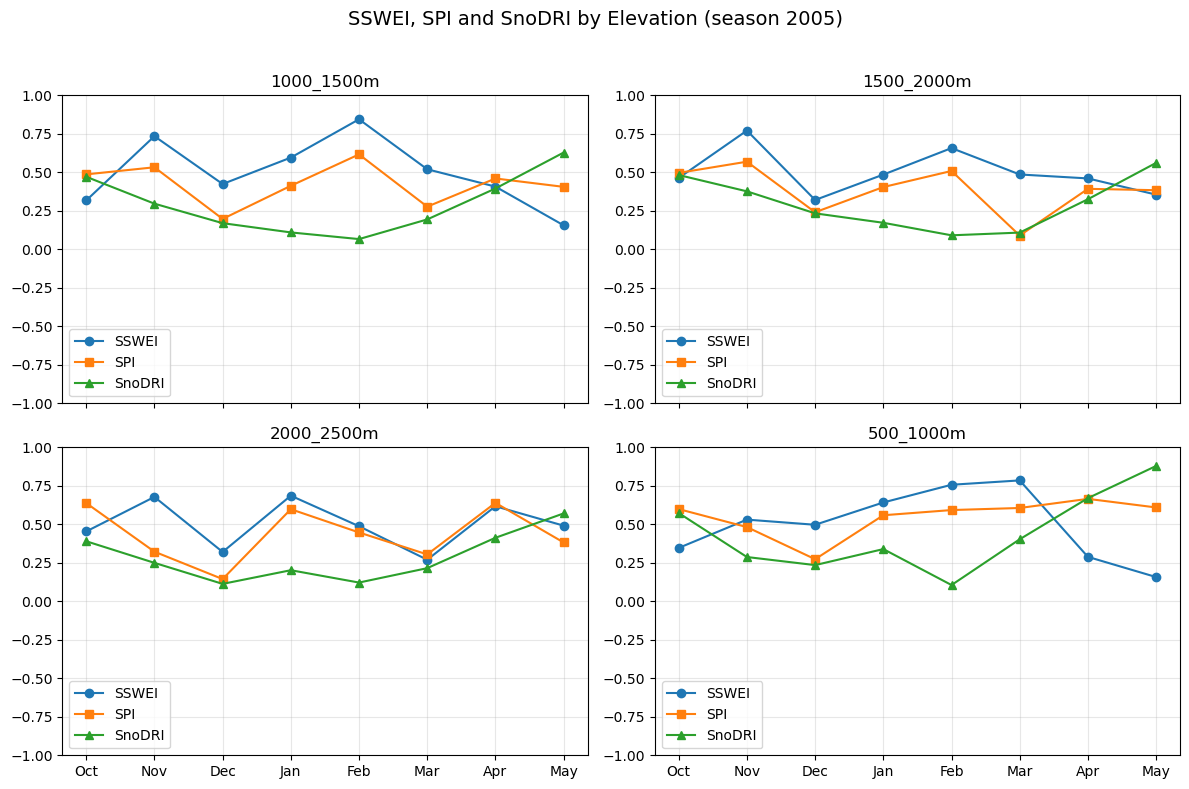

In [ ]:
# Plot merged for each elevation (fix x-axis ordering by using ordinal positions)
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
try:
    merged_sorted = merged_normalized.set_index('month').loc[month_order].reset_index()
except Exception:
    merged_sorted = merged_normalized.copy()

# derive elevation category column names from merged_sorted (those without _SPI/_SnoDRI suffix)
elevations = [c for c in merged_sorted.columns if c != 'month' and not c.endswith('_SPI') and not c.endswith('_SnoDRI')]
# ensure consistent ordering (you can customize if needed)
elevations = sorted(elevations)

# output file for saving the figure
out_file = config['plots'] / 'comparison_2005_by_elevation.png'

fig2, axes2 = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes2 = axes2.flatten()
colors = {'SSWEI': 'tab:blue', 'SPI': 'tab:orange', 'SnoDRI': 'tab:green'}

# use integer x positions so months are plotted in the specified order
x = np.arange(len(merged_sorted))
month_labels = pd.to_datetime(merged_sorted['month'].astype(str), format='%m').dt.strftime('%b')

for i, elev in enumerate(elevations):
    ax = axes2[i]
    ax.plot(x, merged_sorted[elev], marker='o', color=colors['SSWEI'], label='SSWEI')
    ax.plot(x, merged_sorted[f'{elev}_SPI'], marker='s', color=colors['SPI'], label='SPI')
    ax.plot(x, merged_sorted[f'{elev}_SnoDRI'], marker='^', color=colors['SnoDRI'], label='SnoDRI')
    ax.set_title(elev)
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels)
    ax.grid(alpha=0.3)
    ax.legend()

# same y-axis limits for all subplots
ymin = min(merged_sorted[elev].min() for elev in elevations + [f'{elev}_SPI' for elev in elevations] + [f'{elev}_SnoDRI' for elev in elevations])
ymax = max(merged_sorted[elev].max() for elev in elevations + [f'{elev}_SPI' for elev in elevations] + [f'{elev}_SnoDRI' for elev in elevations])
for ax in axes2:
    ax.set_ylim(-1,1)

# hide any remaining axes
for j in range(len(elevations), len(axes2)):
    axes2[j].set_visible(False)

fig2.suptitle('SSWEI, SPI and SnoDRI by Elevation (season 2005)', fontsize=14)
fig2.tight_layout(rect=[0, 0, 1, 0.96])
fig2.savefig(out_file, dpi=300)
plt.show()